In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 666 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shubh556/human-emotion-detection-dataset

 91% 178M/195M [00:03<00:00, 69.3MB/s]
100% 195M/195M [00:03<00:00, 61.9MB/s]


In [ ]:
!unzip "/content/human-emotion-detection-dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Emotions Dataset/train/happy/557853.jpg_brightness_2.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/557853.jpg_rotation_1.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/558.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/558478.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/558478.jpg_brightness_1.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/558478.jpg_brightness_2.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/558478.jpg_rotation_1.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/559.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/559250.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/559250.jpg_brightness_2.jpg  
  inflating: /content/dataset/Emotions Dataset/train/happy/559749.jpg_brightness_1.jpg  
  inflating: /content/dataset/Emotions Dataset/t

In [ ]:
train_dir = '/content/dataset/Emotions Dataset/train'
test_dir = '/content/dataset/Emotions Dataset/test'
class_names = ['angry','happy','sad']

In [ ]:
train_data=keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 9650 files belonging to 3 classes.


In [ ]:
Configuration={
    "BATCH_SIZE" : 32,
    "IMG_SIZE" :  256,
    "LEARNING_RATE" :0.001,
    # "N_EPOCHS" : 20,
    "N_EPOCHS" : 10,
    "DROPOUT_RATE" : 0.00,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" : 3,
}

In [ ]:
test_data=keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=Configuration['BATCH_SIZE'],
    image_size=(Configuration['IMG_SIZE'],Configuration['IMG_SIZE']),
    shuffle=True,
    seed=99,
)

Found 2847 files belonging to 3 classes.


Training Dataset preparation :

In [ ]:
training_dataset = (
    train_data
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    train_data
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
resize_rescale_layers=tf.keras.Sequential(
    [Resizing(Configuration['IMG_SIZE'],Configuration['IMG_SIZE']),
    Rescaling(1/255)]
)

Building our Model

In [ ]:
model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3)),
    resize_rescale_layers,
    Conv2D(filters = Configuration["N_FILTERS"] , kernel_size = Configuration["KERNEL_SIZE"], strides = Configuration["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(Configuration["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = Configuration["POOL_SIZE"], strides= Configuration["N_STRIDES"]*2),
    Dropout(rate = Configuration["DROPOUT_RATE"] ),

    Conv2D(filters = Configuration["N_FILTERS"]*2 + 4, kernel_size = Configuration["KERNEL_SIZE"], strides=Configuration["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(Configuration["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = Configuration["POOL_SIZE"], strides= Configuration["N_STRIDES"]*2),

    Flatten(),

    Dense( Configuration["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(Configuration["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = Configuration["DROPOUT_RATE"]),

    Dense( Configuration['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(Configuration["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(Configuration["NUM_CLASSES"], activation = "softmax"),

])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_44 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 127, 127, 6)       0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 127, 127, 6)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 16)    

In [ ]:
loss_fn=tf.keras.losses.CategoricalCrossentropy() # Defining loss function

In [ ]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=Configuration["LEARNING_RATE"]),
    metrics=metrics,
    loss=loss_fn
)

In [ ]:
history=model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=Configuration["N_EPOCHS"],
    verbose=1,
)

Epoch 1/10
302/302 [==============================] - 613s 2s/step - loss: 0.9749 - accuracy: 0.5378 - top_k_accuracy: 0.8111 - val_loss: 0.9902 - val_accuracy: 0.5017 - val_top_k_accuracy: 0.7869
Epoch 2/10
302/302 [==============================] - 588s 2s/step - loss: 0.7292 - accuracy: 0.6892 - top_k_accuracy: 0.8958 - val_loss: 0.6527 - val_accuracy: 0.7326 - val_top_k_accuracy: 0.9028
Epoch 3/10
302/302 [==============================] - 587s 2s/step - loss: 0.5244 - accuracy: 0.7943 - top_k_accuracy: 0.9400 - val_loss: 0.4091 - val_accuracy: 0.8536 - val_top_k_accuracy: 0.9587
Epoch 4/10
302/302 [==============================] - 583s 2s/step - loss: 0.3559 - accuracy: 0.8720 - top_k_accuracy: 0.9683 - val_loss: 0.5544 - val_accuracy: 0.7858 - val_top_k_accuracy: 0.9292
Epoch 5/10
302/302 [==============================] - 592s 2s/step - loss: 0.2830 - accuracy: 0.9006 - top_k_accuracy: 0.9765 - val_loss: 1.1461 - val_accuracy: 0.4751 - val_top_k_accuracy: 0.7086
Epoch 6/10
302/

Plotting the accuracy

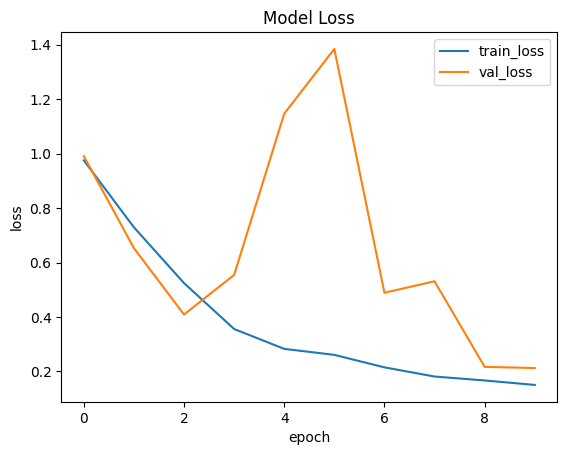

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

Evaluating our model

In [ ]:
model.evaluate(validation_dataset)

302/302 [==============================] - 143s 472ms/step - loss: 0.2127 - accuracy: 0.9259 - top_k_accuracy: 0.9854


[0.21273578703403473, 0.9259067177772522, 0.9853885769844055]

Testing on test dataset

In [ ]:
test_image=cv2.imread("/content/dataset/Emotions Dataset/test/sad/130901.jpg_brightness_2.jpg")

img=tf.constant(test_image,dtype=tf.float32)
# print(img.shape)
img = tf.expand_dims(img,axis=0)
print(class_names[tf.argmax(model(img),axis  = -1 ).numpy()[0]])

sad
